# Imports 

In [1]:
!pip3 install ezdxf
!git clone https://github.com/JarvisSan22/Unet_CrackExtract_to_dxf.git


     |████████████████████████████████| 2.2MB 26.6MB/s 


In [2]:
import tensorflow as tf
import os
import glob
import numpy as np
import shutil

import random
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm  #Progress bar for loops 
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize

import ezdxf 

Driaveをロードする

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#画像の処理


In [4]:
#Image file collect 画像のファイルを集まる
TRAIN_PATH="/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train"
TEST_PATH="/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/test"
train_files=glob.glob(TRAIN_PATH+"/image/***.jpg")
train_labels=glob.glob(TRAIN_PATH+"/label/***.png")
test_files=glob.glob(TEST_PATH+"/test_img/***.jpg")
print(len(train_files),len(train_labels),len(test_files))

300 300 237


In [5]:
train_labels=sorted(train_labels)
train_files=sorted(train_files)

In [6]:
train_labels[0:4],train_files[0:4]

(['/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/label/11111.png',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/label/11112.png',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/label/11113.png',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/label/11114.png'],
 ['/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/image/11111.jpg',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/image/11112.jpg',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/image/11113.jpg',
  '/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/DeepCrack/train/image/11114.jpg'])

## Global setting グロブルの設定

In [7]:
IMG_HEIGHT=128  #256
IMG_WIDTH=128  # 256
IMG_CHANNELS=3

##訓練のデータを準備

In [8]:
X_train= np.zeros((len(train_files),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_train= np.zeros((len(train_files),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool) #True to Flase 

#グレースケールのテスト
GRAY=True
if GRAY:
  X_train= np.zeros((len(train_files),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.uint8)
  y_train= np.zeros((len(train_files),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool) #True to Flase 

In [9]:
#訓練のデータを作成 X : Vectors (images) Y : labels (location boolien)
for n,f in tqdm(enumerate(train_files),total=len(train_files)):
  #img = imread(f)[:,:,:IMG_CHANNELS]  
  if GRAY:
    img=cv2.imread(f,0)
    #img=rgb2gray(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    X_train[n]= img.reshape(IMG_HEIGHT, IMG_WIDTH,1) # img#np.reshape(img,(IMG_HEIGHT,IMG_WIDTH,1) )
  else:
    img = imread(f)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n]= img
  
  mask=np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)
  label=imread(train_labels[n])     #f.replace("image","label"))
  label=resize(label,(IMG_HEIGHT,IMG_WIDTH,1),mode='constant', preserve_range=True)
  ret,thresh = cv2.threshold(label,33,256,cv2.THRESH_BINARY) 

  #mask_=np.expand_dims(label,axis=-1)
  #mask=np.maximum(mask,mask_)
  y_train[n]= np.reshape(thresh,(IMG_HEIGHT,IMG_WIDTH,1) ) #mask


100%|██████████| 300/300 [03:46<00:00,  1.32it/s]


In [10]:
#テストのデータを作成する
X_test = np.zeros((len(test_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)


for n,f in tqdm(enumerate(test_files),total=len(test_files)):
  
  if GRAY:
    img=cv2.imread(f,0)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n]= np.reshape(img,(IMG_HEIGHT,IMG_WIDTH,1) )

  else:
    img = imread(f)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 237/237 [02:11<00:00,  1.81it/s]


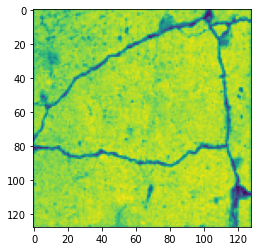

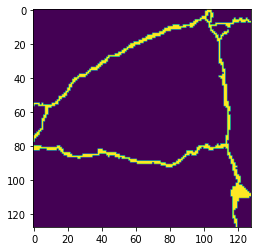

In [11]:
#Test View 
image_x = random.randint(0, len(train_files))
plt.imshow(np.squeeze(X_train[image_x]))
plt.show()
plt.imshow(np.squeeze(y_train[image_x]))
plt.show()

#モデル: Unet

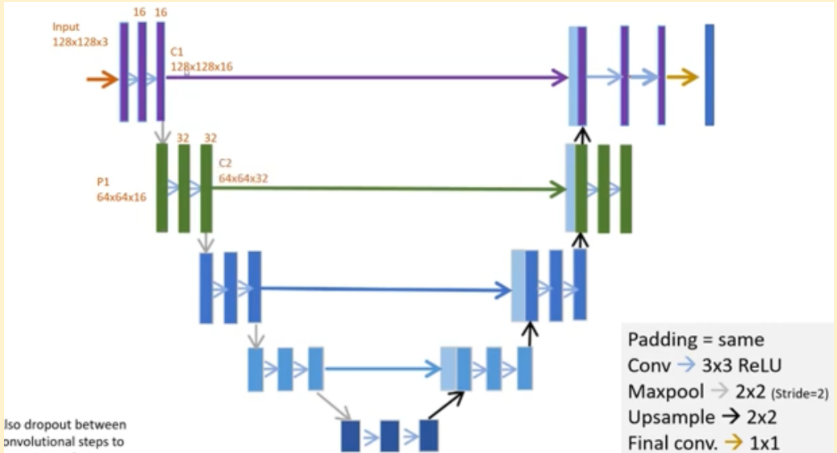

In [50]:
if GRAY:
  IMG_CHANNELS=1
def model_UNET_1(imagesize=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),factor=1):
  
  inputs = tf.keras.layers.Input(imagesize) #出力
  #畳み込み
  s = tf.keras.layers.Lambda(lambda x:x/255)(inputs) #Int -> float points 
  c1=tf.keras.layers.Conv2D(16*factor,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(s)
  #kernel_initilizaer -> 最初期のWeights 
  c1=tf.keras.layers.Dropout(0.1)(c1) #10%
  c1=tf.keras.layers.Conv2D(16*factor,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
  #Maxpooling
  p1=tf.keras.layers.MaxPooling2D((2,2))(c1)


  c2 = tf.keras.layers.Conv2D(32*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path Back up 拡張経路　
  u6 = tf.keras.layers.Conv2DTranspose(128*factor, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64*factor, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32*factor, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16*factor, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16*factor, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  #出力
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  #optimzier -> 訓練のAlgorithms adam(一般的)
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','binary_crossentropy'])
  model.summary()
  return model

#標準のモデル
model_1=model_UNET_1()
#大きなモデル
model_2=model_UNET_1(factor=2)
#小さいなモデル
model_3=model_UNET_1(factor=0.5)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 128, 128, 1)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 128, 128, 16) 160         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 128, 128, 16) 0           conv2d_133[0][0]                 
____________________________________________________________________________________________

In [ ]:
def model_UNET_2(imagesize=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),weights_input=None):

    inputs = inputs = tf.keras.layers.Input(imagesize)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv1)
    pool1 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 =tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool1)
    conv2 =tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv2)
    pool2 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool2)
    conv3 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv3)
    pool3 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)
    #Expansive path Back up 拡張経路　
    up6 = tf.keras.layers.Conv2D(512, 2, activation="relu", padding="same", kernel_initializer="he_normal")( tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.Concatenate(axis=3)([drop4,up6])
    conv6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.Concatenate(axis=3)([conv3,up7])
    conv7 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.Concatenate(axis=3)([conv2,up8])
    conv8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.Concatenate(axis=3)([conv1,up9])
    conv9 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge9)
    conv9 =tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv9)

    conv10 = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    if weights_input:
        model.load_weights(weights_input)
    model.summary()
    return model

model_2=model_UNET_2()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
def prepare_input(image):
    image = np.reshape(image, image.shape+(1,))
    image = np.reshape(image,(1,)+image.shape)
    image = np.clip(image, 0, 255)
    return np.divide(image, 255)



##Model checkpoint settings モデルを確認するところの設定

In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_for_cracks.h5",verbose=1,save_best_only=True)

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=5,monitor="val_loss"),
             tf.keras.callbacks.TensorBoard(log_dir="logs")
]

## Moddeling fitting モデル

訓練のデータはモデルに入り込んで、訓練を行う。

In [ ]:
models={"standard":model_1,"small":model_3,"large":model_2}
model_results={}

epochs=50
batch_size=15
DATE=20210702
for key,model in models.items():
    print(f'{"="*25} model {key} {"="*25}')
    print(key)
    results = model.fit(
        X_train,
        y_train,
        validation_split=0.1
        ,batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
        )
    model.save(f'UNET1_{key}_ep{epochs}_bs{batch_size}_{DATE}.h5')
    model_results[key]=results


========================= model small =========================
small
Epoch 1/50
18/18 [==============================] - 24s 1s/step - loss: 0.3258 - accuracy: 0.9471 - binary_crossentropy: 0.3258 - val_loss: 0.3061 - val_accuracy: 0.9723 - val_binary_crossentropy: 0.3061
Epoch 2/50
18/18 [==============================] - 21s 1s/step - loss: 0.1858 - accuracy: 0.9589 - binary_crossentropy: 0.1858 - val_loss: 0.2083 - val_accuracy: 0.9724 - val_binary_crossentropy: 0.2083
Epoch 3/50
18/18 [==============================] - 21s 1s/step - loss: 0.1650 - accuracy: 0.9590 - binary_crossentropy: 0.1650 - val_loss: 0.1483 - val_accuracy: 0.9724 - val_binary_crossentropy: 0.1483
Epoch 4/50
18/18 [==============================] - 21s 1s/step - loss: 0.1520 - accuracy: 0.9590 - binary_crossentropy: 0.1520 - val_loss: 0.1313 - val_accuracy: 0.9724 - val_binary_crossentropy: 0.1313
Epoch 5/50
18/18 [==============================] - 20s 1s/step - loss: 0.1369 - accuracy: 0.9590 - binary_crossen

In [124]:
model.save(f'UNET1_{key}_ep{epochs}_bs{batch_size}_{DATE}.h5')
model_results[key]=results

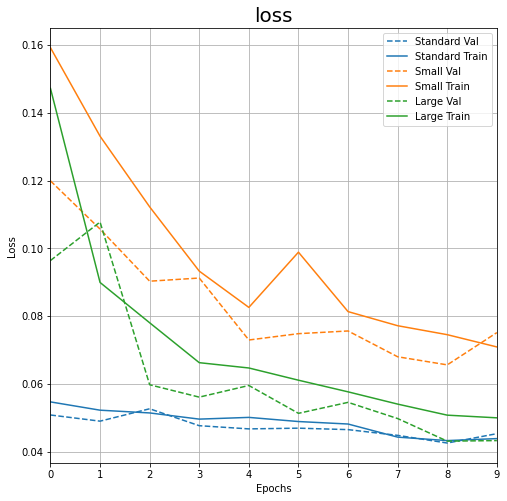

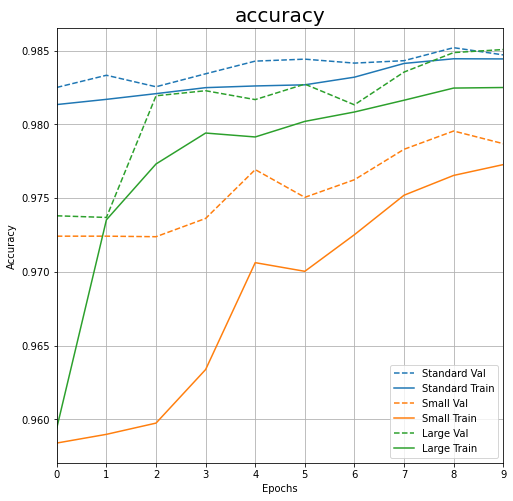

In [62]:
def plot_history(results, keys=['loss', 'accuracy',]):
  for key in keys:
    plt.figure(figsize=(8,8))
    for name, history in results.items():
      val = plt.plot(history.epoch, history.history["val_"+key],
                    '--', label=name.title()+' Val')
      plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
              label=name.title()+' Train')
    plt.title(key,fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.grid()
plot_history(model_results)

## Predict Test data テストのデータを予想する

In [63]:
pred_tests={}


for key,model in models.items():
  print(f'{"="*25} model {key} {"="*25}')
  pred_tests[key]=model.predict(X_test,verbose=2)
  
  
 

========================= Chain standard =========================
8/8 - 9s
========================= Chain small =========================
8/8 - 4s
========================= Chain large =========================
8/8 - 27s


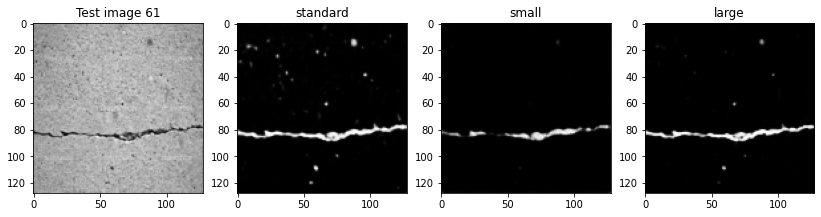

In [85]:
ix=random.randint(0,len(X_test))
figs,axs=plt.subplots(1,len(models)+1,figsize=(14,8))
i=1
axs[0].imshow(np.squeeze(X_test[ix]),"gray")
axs[0].set_title(f"Test image {ix}")
for key,pred in pred_tests.items():
  #print(key)
  axs[i].imshow(np.squeeze(pred[ix]),cmap="gray")
  axs[i].set_title(key)
  i+=1

#画像の亀裂は輪郭とdfxのファイルへ変換する

In [86]:
#モデルの予想の画像は正規化から戻る
def prepare_output(image):
    image = image[:,:,0]
    image = np.clip(image, 0, 1)
    return np.multiply(image, 255)
#表示
def imshow_ccbar(image,cmap="reds",title=None):
  plt.figure()
  im=plt.imshow(image)
  plt.colorbar(im,cmap=cmap)
  if title:
    plt.title(title)
  plt.show()
  
#閾値
def threshold(image, min_limit=None, max_limit=256, clip=0):
    if min_limit is None:
        min_limit = int(np.mean(image) + clip)

    _, image = cv2.threshold(image, min_limit, max_limit, cv2.THRESH_BINARY)
    return image
#輪郭を抽出する
def predToContours(img_pred,img_original,thresh_mim=55,MIN_C=20,plot=False):
  #正規化から0-255の数へ変換する
  img_p1=prepare_output(img_pred)
  if plot:
    imshow_ccbar(img_p1,title="0-255")
  #平滑化 ぼかし
  img_p2 = cv2.GaussianBlur(img_p1,(3,3), 1)
  if plot:
    imshow_ccbar(img_p2,title="GaussianBlur")
  #閾値
  img_p3 = threshold(img_p2, min_limit=thresh_mim)
  if plot:
     imshow_ccbar(img_p3,title="threshhold")
  
  #輪郭の機能で扱いデータの形式 uint8へ変換する
  img_p3=cv2.convertScaleAbs(img_p3)
  #輪郭
  contours, hierarchy = cv2.findContours(img_p3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  #小さいな輪郭を抜ける
  usecontours=[]
  
  for contour in contours:
    if len(contour)>=MIN_C:
      usecontours.append(contour)
  if plot:
    new_img=cv2.drawContours(img_original,usecontours,-1,color=(0,0,255),thickness=2)
    plt.figure()
    plt.imshow(new_img,cmap="gray")
    plt.title("Contours")
  return usecontours

#輪郭からdxfのファイルを変換する
def ContoursToDxf(contours,savename):
    #dxf file creation dxfのファイルを作成する
    dwg = ezdxf.new("R2010")
    msp = dwg.modelspace()
    #亀裂のレイヤーを作成
    dwg.layers.new(name="Crack",dxfattribs={"color":3})
    #Add contors to dxf dfxには輪郭を加える

    for ctr in contours:
        for i in range(len(ctr)):
            j= i+1
            if j>=len(ctr):
                j=0
            try:
                msp.add_line(ctr[i][0],ctr[j][0], dxfattribs={'layer':"Crack"})
            except Exception as e:
                print(ctr[i],'->',ctr[j])
                print(e.args)

    dwg.saveas(f'{savename}.dxf')

========================= model standard =========================


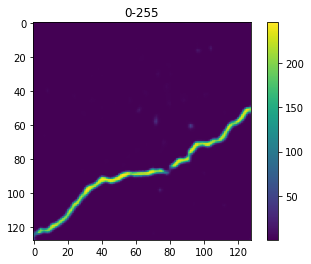

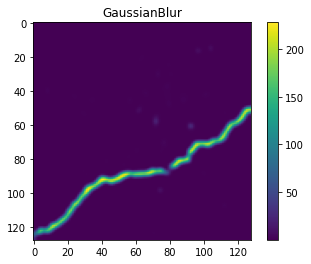

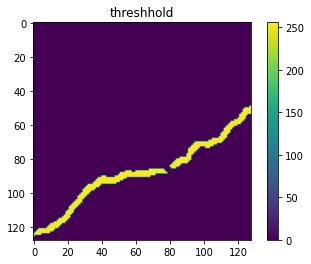

========================= =========================
========================= model small =========================


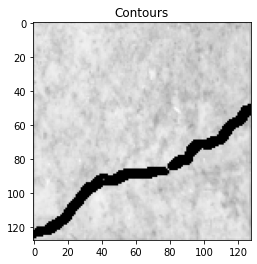

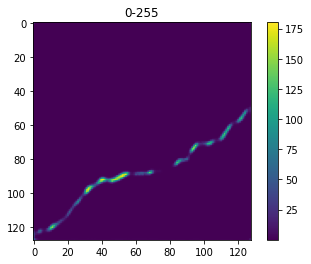

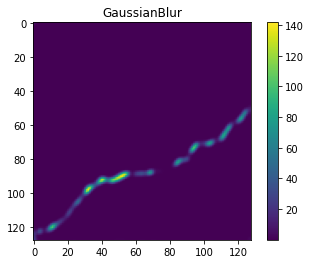

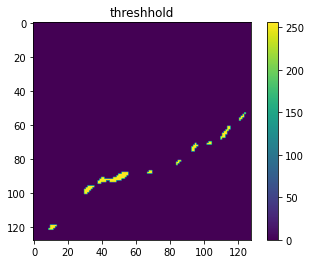

========================= =========================
========================= model large =========================


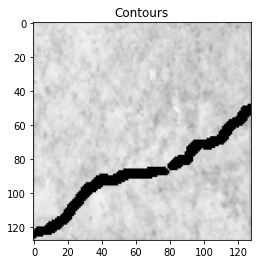

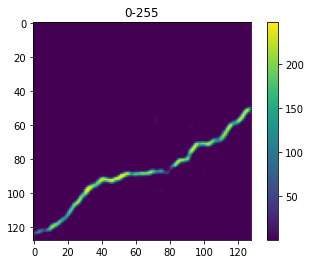

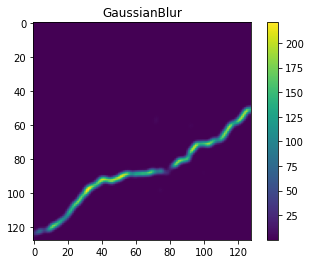

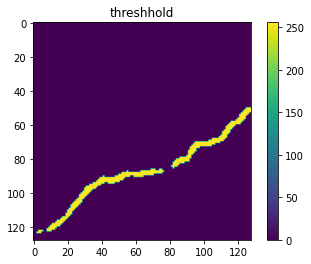

========================= =========================


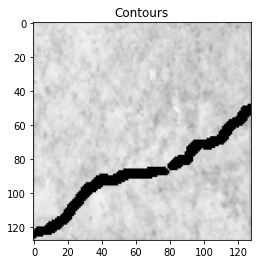

In [90]:
#ランダムの画像とテスト
ix=random.randint(0,len(X_test))
img_original=X_test[ix]


for key,pred in pred_tests.items():
  print(f'{"="*25} model {key} {"="*25}')
  img_pred=pred[ix]
  savename = f"test_crack_%003d_{key}" % (ix)
  contours=predToContours(img_pred,np.squeeze(img_original),MIN_C=20,plot=True)
  ContoursToDxf(contours,savename)
